# ***Asterix with DQN***

## ***DQN Architecture Details***

### **Convolutional Layer**
  - **Type:** Convolutional 2D Layer
  - **Parameters:**
    - `output_channels`: 16
    - `kernel_shape`: 3
    - `stride`: 1
  - **Activation Function:** ReLU (applied after convolutional layer)


### **Fully Connected Layer (MLP)**
  - **Type:** Multi-Layer Perceptron (MLP)
  - **Parameters:**
    - `output_sizes`: [128, `env.n_actions`]
    - `activation`: ReLU
    - `activate_final`: False
  - **Input Transformation:** Input is reshaped to a 1D array before being passed to the MLP


In [12]:
import sys
import jax
import jax.numpy as jnp
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import optax
import haiku as hk
import plotly.graph_objects as go
import numpy as np
import gymnax

from typing import Callable, List
from functools import partial
from jax import random, vmap, lax, jit
from jax_tqdm import loop_tqdm

sys.path.append("../../")
from jym import BaseDeepRLAgent, Experience, DQN, UniformReplayBuffer

## ***Hyperparameters***

References:
* [*Dopamine: A Research Framework for Reinforcement Learning*](https://arxiv.org/pdf/1812.06110.pdf)
* [*Large Batch Experiences Replay*](https://arxiv.org/pdf/2110.01528.pdf)

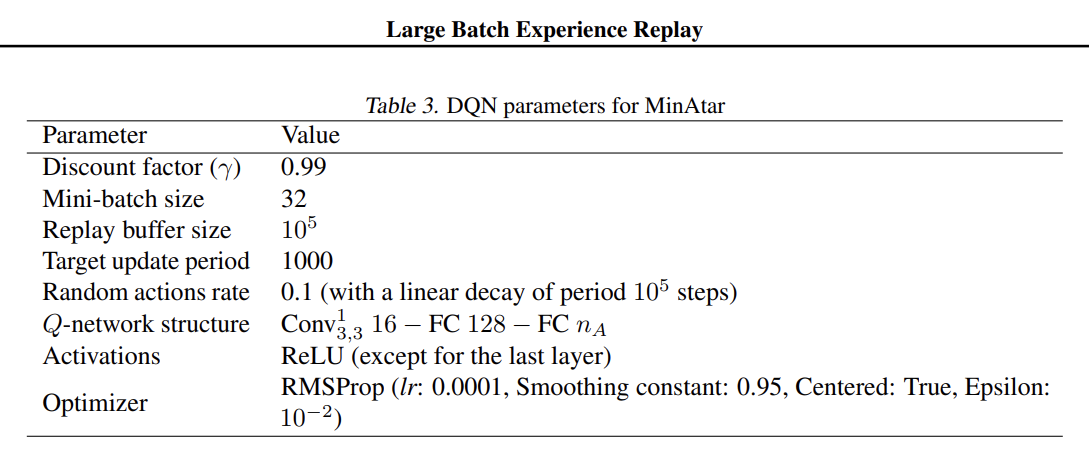

In [13]:
# MinAtar Breakout params
DISCOUNT = 0.99
BATCH_SIZE = 32
BUFFER_SIZE = 100_000
TARGET_NET_UPDATE_FREQ = 1000


# other params
RANDOM_SEED = 0
STATE_SHAPE = (10, 10, 4)
N_ACTIONS = 3

CONV_LAYER_PARAMS = {
    "output_channels": 16,
    "kernel_shape": 3,
    "stride": 1,
}
MLP_PARAMS = {
    "output_sizes": [128, N_ACTIONS],
    "activation": jax.nn.relu,
    "activate_final": False,
}
OPTIMIZER_PARAMS = {
    "learning_rate": 1e-4,
    "decay": 0.95,  # named `smoothing constant` in the paper
    "centered": True,
    "eps": 10e-2,
}
EPSILON_DECAY_PARAMS = {
    "epsilon_start": 0.1,
    "epsilon_end": 0,
    "decay_period": 100_000,
}

In [14]:
def gymnax_rollout(
    timesteps: int,
    target_net_update_freq: int,
    model: hk.Transformed,
    optimizer: optax.GradientTransformation,
    buffer_state: dict,
    agent: BaseDeepRLAgent,
    env_name: str,
    state_shape: int,
    buffer_size: int,
    batch_size: int,
    epsilon_decay_fn: Callable,
    decay_params: dict,
    buffer_start_size: int = 0,
) -> dict[jnp.ndarray | dict]:
    @loop_tqdm(timesteps)
    @jit
    def _fori_body(i: int, val: tuple):
        (
            online_net_params,
            target_net_params,
            optimizer_state,
            buffer_state,
            rng,
            state,
            obs,
            all_actions,
            all_obs,
            all_rewards,
            all_done,
            losses,
        ) = val

        rng, env_key, action_key, buffer_key = jax.random.split(rng, 4)
        epsilon = epsilon_decay_fn(current_step=i, **decay_params)
        action, action_key = agent.act(action_key, online_net_params, obs, epsilon)

        next_state, state, reward, done, _ = env.step(
            env_key, state, action, env_params
        )

        experience = (env.get_obs(state), action, reward, next_state, done)

        buffer_state = replay_buffer.add(
            buffer_state, experience, buffer_start_size + i
        )
        current_buffer_size = jnp.min(jnp.array([buffer_start_size + i, buffer_size]))

        experiences_batch, buffer_key = replay_buffer.sample(
            buffer_key, buffer_state, current_buffer_size
        )

        online_net_params, optimizer_state, loss = agent.update(
            online_net_params,
            target_net_params,
            optimizer,
            optimizer_state,
            experiences_batch,
        )

        # update the target parameters every ``target_net_update_freq`` steps
        target_net_params = lax.cond(
            i % target_net_update_freq == 0,
            lambda _: online_net_params,
            lambda _: target_net_params,
            operand=None,
        )

        all_actions = all_actions.at[i].set(action)
        all_obs = all_obs.at[i].set(next_state)
        all_rewards = all_rewards.at[i].set(reward)
        all_done = all_done.at[i].set(done)
        losses = losses.at[i].set(loss)

        val = (
            online_net_params,
            target_net_params,
            optimizer_state,
            buffer_state,
            rng,
            state,
            obs,
            all_actions,
            all_obs,
            all_rewards,
            all_done,
            losses,
        )

        return val

    key = random.PRNGKey(0)
    rng, init_key, _, _ = jax.random.split(key, 4)
    env, env_params = gymnax.make(env_name)
    obs, state = env.reset(init_key, env_params)
    all_actions = jnp.zeros([timesteps])
    all_obs = jnp.zeros([timesteps, *state_shape])
    all_rewards = jnp.zeros([timesteps], dtype=jnp.float32)
    all_done = jnp.zeros([timesteps], dtype=jnp.bool_)
    losses = jnp.zeros([timesteps], dtype=jnp.float32)

    online_net_params = model.init(init_key, jnp.zeros(state_shape))
    target_net_params = model.init(init_key, jnp.zeros(state_shape))
    optimizer_state = optimizer.init(online_net_params)
    replay_buffer = UniformReplayBuffer(buffer_size, batch_size)

    val_init = (
        online_net_params,
        target_net_params,
        optimizer_state,
        buffer_state,
        rng,
        state,
        obs,
        all_actions,
        all_obs,
        all_rewards,
        all_done,
        losses,
    )

    vals = lax.fori_loop(0, timesteps, _fori_body, val_init)
    output_dict = {}
    keys = [
        "online_net_params",
        "target_net_params",
        "optimizer_state",
        "buffer_state",
        "rng",
        "state",
        "obs",
        "all_actions",
        "all_obs",
        "all_rewards",
        "all_done",
        "losses",
    ]
    for idx, value in enumerate(vals):
        output_dict[keys[idx]] = value

    return output_dict

In [15]:
key = random.PRNGKey(0)
env, env_params = gymnax.make("Asterix-MinAtar")
# env, env_params = gymnax.make("Breakout-MinAtar")


@hk.transform
def model(x):
    """
    MinAtar version of DQN
    ref: https://github.com/kenjyoung/MinAtar/blob/master/examples/dqn.py
    """
    conv_layer = hk.Conv2D(**CONV_LAYER_PARAMS)
    fc = hk.nets.MLP(**MLP_PARAMS)

    x = jax.nn.relu(conv_layer(x))
    x = x.reshape(-1)
    return fc(x)


def linear_decay(
    epsilon_start: float,
    epsilon_end: float,
    current_step: int,
    decay_period: int,
) -> float:
    decay_rate = (epsilon_start - epsilon_end) / decay_period
    new_epsilon = epsilon_start - current_step * decay_rate
    return jnp.maximum(jnp.float32(epsilon_end), new_epsilon)


replay_buffer = UniformReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
online_key, target_key = vmap(random.PRNGKey)(jnp.arange(2) + RANDOM_SEED)

online_net_params = model.init(online_key, random.normal(online_key, env.obs_shape))
target_net_params = model.init(target_key, random.normal(target_key, env.obs_shape))

optimizer = optax.rmsprop(**OPTIMIZER_PARAMS)
optimizer_state = optimizer.init(online_net_params)

agent = DQN(model, DISCOUNT, env.num_actions)

jax.tree_map(lambda x: x.shape, online_net_params)

{'conv2_d': {'b': (16,), 'w': (3, 3, 4, 16)},
 'mlp/~/linear_0': {'b': (128,), 'w': (1600, 128)},
 'mlp/~/linear_1': {'b': (3,), 'w': (128, 3)}}

In [16]:
buffer_state = {
    "states": jnp.empty((BUFFER_SIZE, *STATE_SHAPE), dtype=jnp.float32),
    "actions": jnp.empty((BUFFER_SIZE,), dtype=jnp.int32),
    "rewards": jnp.empty((BUFFER_SIZE,), dtype=jnp.int32),
    "next_states": jnp.empty((BUFFER_SIZE, *STATE_SHAPE), dtype=jnp.float32),
    "dones": jnp.empty((BUFFER_SIZE,), dtype=jnp.bool_),
}
jax.tree_map(lambda x: x.shape, buffer_state)

{'actions': (100000,),
 'dones': (100000,),
 'next_states': (100000, 10, 10, 4),
 'rewards': (100000,),
 'states': (100000, 10, 10, 4)}

In [17]:
def prefill_buffer(buffer_state: dict, n_experiences: int):
    @loop_tqdm(n_experiences)
    @jit
    def _fori_body(i, val):
        (obs, state, buffer_state, action_key, env_key) = val
        action, action_key = agent.act(
            action_key, online_net_params, obs, epsilon=1
        )  # random actions
        next_state, state, reward, done, _ = env.step(
            env_key, state, action, env_params
        )
        experience = (env.get_obs(state), action, reward, next_state, done)

        buffer_state = replay_buffer.add(buffer_state, experience, i)
        return (obs, state, buffer_state, action_key, env_key)

    key = random.PRNGKey(1)
    action_key, env_key = jax.random.split(key, 2)
    obs, state = env.reset(env_key)
    val_init = (obs, state, buffer_state, action_key, env_key)
    val =  lax.fori_loop(
        0, n_experiences, _fori_body, val_init
    )
    buffer_state = val[2]
    return buffer_state
    

buffer_state = prefill_buffer(buffer_state, 5000)

c:\Users\ryanp\AppData\Local\pypoetry\Cache\virtualenvs\jax-rl-KPtyfD6I-py3.10\lib\site-packages\jax\_src\ops\scatter.py:94: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



c:\Users\ryanp\AppData\Local\pypoetry\Cache\virtualenvs\jax-rl-KPtyfD6I-py3.10\lib\site-packages\jax\_src\ops\scatter.py:94: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.

Running for 5,000 iterations: 100%|██████████| 5000/5000 [00:00<00:00, 9649.79it/s] 


In [18]:
rollout_params = {
    "timesteps": 100_000,
    "target_net_update_freq": TARGET_NET_UPDATE_FREQ,
    "model": model,
    "optimizer": optimizer,
    "buffer_state": buffer_state,
    "agent": agent,
    "env_name": "Asterix-MinAtar",
    # "env_name": "Breakout-MinAtar",
    "state_shape": STATE_SHAPE,
    "buffer_size": BUFFER_SIZE,
    "batch_size": BATCH_SIZE,
    "epsilon_decay_fn": linear_decay,
    "decay_params": EPSILON_DECAY_PARAMS,
}

out = gymnax_rollout(**rollout_params)

Running for 100,000 iterations: 100%|██████████| 100000/100000 [04:11<00:00, 398.28it/s]


In [19]:
out['all_done'].sum()

Array(979, dtype=int32)

In [23]:
px.line(out["losses"], title="Loss during training")

In [21]:
df = pd.DataFrame(
    data={
        "episode": out["all_done"].cumsum(),
        "reward": out["all_rewards"],
    },
)
df["episode"] = df["episode"].shift().fillna(0)
episodes_df = df.groupby("episode").agg("sum")

px.line(
    episodes_df,
    y="reward",
    title=f"Performances of DQN on the Breakout Environment",
)

In [24]:
px.scatter(out["all_actions"])